# 가위바위보 분류기를 만들자

### 라이브러리 버전 확인

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


### 데이터 불러오기 + Resize 하기

In [2]:
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


### 이미지의 크기를 28 x 28로 만든다

In [3]:
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")

# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

571  images to be resized.
571  images resized.
가위 이미지 resize 완료!
569  images to be resized.
569  images resized.
바위 이미지 resize 완료!
570  images to be resized.
570  images resized.
보 이미지 resize 완료!


### load_data() 함수 만들기

In [4]:
# 가위바위보 데이터를 읽을 수 있는 load_data() 함수 만들기
import numpy as np

def load_data(img_path, number_of_data=1710):  # 가위바위보 이미지 개수 총합: 1710
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

# 훈련셋과 검증셋 분리
x_val = x_train[1301:]
y_val = y_train[1301:]
x_train = x_train[:1301]
y_train = y_train[:1301]

x_val_norm = x_val/255.0 # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("x_val shape: {}".format(x_val.shape))
print("y_val shape: {}".format(y_val.shape))

x_train shape: (1301, 28, 28, 3)
y_train shape: (1301,)
x_val shape: (409, 28, 28, 3)
y_val shape: (409,)


### 딥러닝 네트워크 설계하기

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# 모델 만들기
# 텐서플로우(TensorFlow)의 표준 API인 tf.keras의 Sequential API를 이용
n_channel_1=16  # 얼마나 다양한 이미지의 특징을 살펴볼 것인가?
n_channel_2=32
n_dense=38    # 분류기 알고리즘을 얼마나 복잡하게 할 것인가? (복잡한 문제일수록 늘릴 것)
n_train_epoch=3    # 가위바위보의 분류기 값이므로 3으로 맞춰준다(가위, 바위, 보)

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))    # RGB 색상이므로 28,28,'3'
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(n_train_epoch, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers)) 

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 38)                30438     
_________________________________________________________________
dense_1 (Dense)              (No

### 딥러닝 네트워크 학습시키기

In [6]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
41/41 [==============================] - 3s 10ms/step - loss: 4.7474 - accuracy: 0.4489 - val_loss: 5.2071 - val_accuracy: 0.0049
Epoch 2/100
41/41 [==============================] - 0s 4ms/step - loss: 1.3494 - accuracy: 0.5296 - val_loss: 5.0036 - val_accuracy: 0.0000e+00
Epoch 3/100
41/41 [==============================] - 0s 4ms/step - loss: 1.2605 - accuracy: 0.5350 - val_loss: 2.3680 - val_accuracy: 0.1198
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 1.0601 - accuracy: 0.5696 - val_loss: 1.1821 - val_accuracy: 0.4352
Epoch 5/100
41/41 [==============================] - 0s 4ms/step - loss: 0.8957 - accuracy: 0.6303 - val_loss: 1.7093 - val_accuracy: 0.2567
Epoch 6/100
41/41 [==============================] - 0s 4ms/step - loss: 0.8097 - accuracy: 0.6533 - val_loss: 1.4262 - val_accuracy: 0.3839
Epoch 7/100
41/41 [==============================] - 0s 4ms/step - loss: 0.7914 - accuracy: 0.6633 - val_loss: 2.7241 - val_accuracy: 0.0905
Epoch 8/

Epoch 59/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0998 - accuracy: 0.9700 - val_loss: 1.2012 - val_accuracy: 0.6455
Epoch 60/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0970 - accuracy: 0.9693 - val_loss: 1.1929 - val_accuracy: 0.6406
Epoch 61/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0868 - accuracy: 0.9792 - val_loss: 1.3179 - val_accuracy: 0.6015
Epoch 62/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0888 - accuracy: 0.9754 - val_loss: 1.1711 - val_accuracy: 0.6528
Epoch 63/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0684 - accuracy: 0.9862 - val_loss: 1.2888 - val_accuracy: 0.6015
Epoch 64/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0567 - accuracy: 0.9900 - val_loss: 1.2808 - val_accuracy: 0.6284
Epoch 65/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0651 - accuracy: 0.9816 - val_loss: 1.2562 - val_accuracy: 0.6406
Epoch 

### 얼마나 잘 만들었는지 확인하기(테스트)

In [7]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
resize_images(image_dir_path)
# 테스트 가위 이미지 resize 완료

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path)
# 테스트 바위 이미지 resize 완료

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)
# 테스트 보 이미지 resize 완료

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

130  images to be resized.
130  images resized.
130  images to be resized.
130  images resized.
130  images to be resized.
130  images resized.
x_test shape: (1710, 28, 28, 3)
y_test shape: (1710,)


In [8]:
# loss, accuracy 체크

test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}") 

54/54 - 0s - loss: 1.4779 - accuracy: 0.9088
test_loss: 1.4778987169265747
test_accuracy: 0.9087719321250916


### 시각화하기

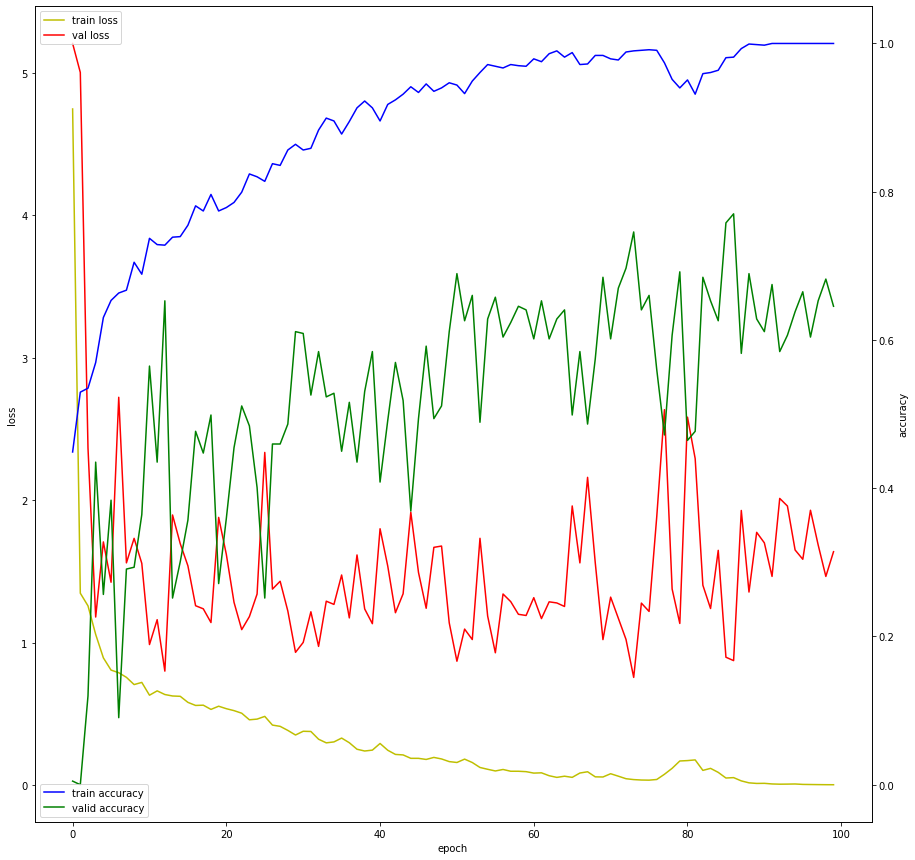

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(15,15))
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

<회고> <br>

가위바위보 분류기를 만드는 실습을 해보았는데,<br> 
텐서플로우를 활용해서 모델 학습을 할 수 있다는 게 참 편리하다는 생각이 들었다.<br>

- 데이터 불러와서 resize 하기
- load_data() 함수 만들기
- 딥러닝 네트워크 설계: (tensowflow의 표준 API인 tf.keras의 Sequential API를 이용)
- 딥러닝 네트워크 학습시키기: model.compile, model.fit
- 테스트하기: 테스트 데이터 불러와서 resize, 정규화
- loss, accuracy 확인

<br>
위 순서로 진행된다는 흐름을 알 수 있었다.

<br>
분류기 사용에 앞서서, 해당 노드에서 300장의 사진 데이터를 이용해보라는 권유가 있었는데<br>
데이터량이 많을 수록 ac*curacy가 높아지지 않을까 싶어, <br>
조원들과 함께 가위바위보 손 사진을 찍어 해당 사진 데이터로 분류기 작업을 진행하였다. <br>
보통 train:val:test 데이터의 값을 6:2:2 정도로 진행하기에, <br>
총 2100장의 사진을 가지고, <br>
train에는 약 1301개, <br>
validation에는 약 409개, <br>
test에는 약 390개의 사진을 할당하여 분류 작업을 진행하였다.<br>
<br>
test 셋은 파일을 따로 나누어 두었고, <br>
train과 val은 train에서 val을 슬라이싱하여 할당하는 방식으로 하였다. <br>
<br>

처음에는 validation을 따로 지정하지 않고, train/test만 두고 모델학습을 진행하였는데 <br>
test accuracy : 약 81.43%에 도달했었는데, <br>
validation을 지정하여 모델학습을 진행하니,
- 최종 test accuracy : 약 90.87%에 도달할 수 있었다.
(하지만, 모델을 돌릴 때마다 accuracy 값이 좀 널뛰기 하는 경향이 있었다, 10%대로 나오기도 하고... <br>
안정성이 부족한 것 같은데 이에 대한 문제 해결은 이후에 더 알아봐야 할 것 같다)

<br>
accuracy를 높이기 위한 방법으로 <br>
epoch 값을 100으로 지정하고 <br>
dense 값도 약간 올려주었다 (가위바위보 데이터가 약간 많아서 복잡한 문제라고 판단)